# 15 - Lotka-Volterra model

##### Imports:

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.integrate as integrate

##### Functions:

Note: exponential works as follows:

In [4]:
def update_state(state, reaction):
    X1 = state[0]
    X2 = state[1]
    
    if reaction == 1:
        new_X1 = X1 + 1
        new_X2 = X2
        
    if reaction == 2:
        new_X1 = X1 - 1
        new_X2 = X2 + 1
        
    if reaction == 3:
        new_X1 = X1
        new_X2 = X2 - 1
    
    return (new_X1, new_X2)

In [156]:
def gillespie_step(state, t):
    ## state is the given state of the system X_1, ..., X_N; define these variables
    X1 = state[0]
    X2 = state[1]
    
    ## Compute the rates
    a1 = k1*X1
    a2 = k2*X1*X2
    a3 = k3*X2
    a0 = a1 + a2 + a3
    
    beta = 1/a0
    
    ## Update the time
    tau = np.random.exponential(beta)
    new_time = t + tau
    
    ## Choose a reaction
    r = random.uniform(0, 1)
    if r <= a1/a0:
        reaction = 1
    if r > a1/a0 and r<= (a1 + a2)/a0:
        reaction = 2
    if r > (a1 + a2)/a0:
        reaction = 3
        
    ## Update according to chosen reaction
    new_state = update_state(state, reaction)
    
    
    return (new_state, new_time)

In [169]:
def gillespie_algorithm(initial, end_time = 10**4):
    time = 0
    states = [initial]
    times = [0]
    
    # # Adaption of the algorithm: stop if a certain time is reached OR extinction occurred:
    while times[-1] <= end_time and states[-1][0] != 0 and states[-1][1] != 0:
    
    ## Perform the algorithm as long as populations don't go extinct
    #while states[-1][0] != 0 and states[-1][1] != 0:
        new_state, new_time = gillespie_step(states[-1], times[-1])
        states.append(new_state)
        times.append(new_time)
    
    return (states, times)

# 15.1 - Compute trajectories

Initialise the rates and the initial conditions given in the problem.

In [158]:
k1 = 1; k2 = 0.005; k3 = 0.6
initial = (100, 20)

For information, the non-zero stationary solution is given by the initial conditions:

In [159]:
print(k3/k2, k1/k2)

120.0 200.0


X1 is extinct


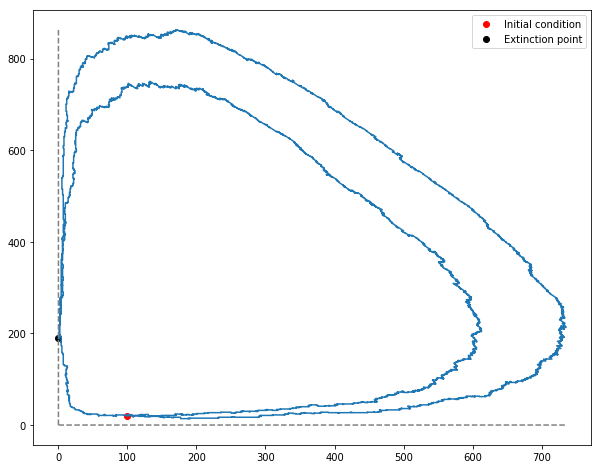

In [167]:
# Obtain the states:
states, times = gillespie_algorithm(initial) 

# Before plotting: determine end scenario:
extinct = False

if states[-1][0] == 0:
    extinct = True
    print('X1 is extinct')
if states[-1][1] == 0:
    extinct = True
    print('X2 is extinct')    

# Plot the X1, X2 trajectories:
xdata = [x[0] for x in states]
ydata = [x[1] for x in states]

tx = np.arange(0, np.max(xdata), 0.01)
ty = np.arange(0, np.max(ydata), 0.01)

plt.subplots(figsize =(10, 8))
plt.scatter(initial[0], initial[1], marker = 'o', color = 'red', label = 'Initial condition')
if extinct:
    plt.scatter(xdata[-1], ydata[-1], marker = 'o', color = 'black', label = 'Extinction point')
plt.plot(xdata, ydata)
plt.plot([0 for val in ty], ty, '--', color = 'grey')
plt.plot(tx, [0 for val in tx], '--', color = 'grey')
plt.legend()
plt.show()

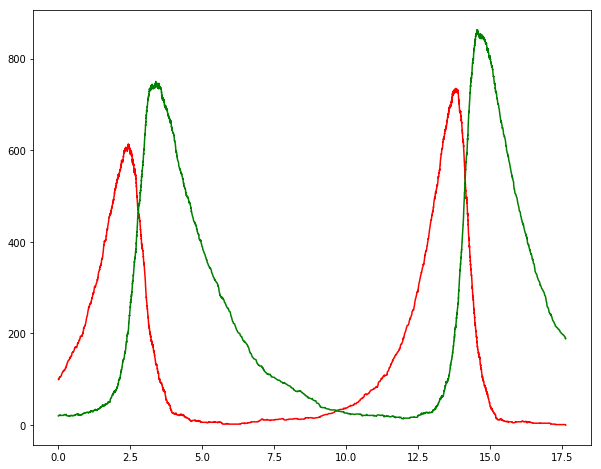

In [168]:
# Plot X1(t) and X2(t):
plt.subplots(figsize =(10, 8))
plt.plot(times, xdata, color = 'red', label = 'X1')
plt.plot(times, ydata, color = 'green', label = 'X2')
plt.show()

## 15.2 - Absorbing states: estimate of oscillations

???

## 15.3 - Absorbing states: comparison between two states

How often does system end in $X_1 = X_2 = 0$ compared to $X_1 \to +\infty, X_2 = 0$?

In [197]:
## Choose how often the algorithm should be runned
nreps = 100

X1_extinct = 0
X2_extinct = 0

time_limit = 10**4

for i in range(nreps):
    states, times = gillespie_algorithm(initial, time_limit)
    if states[-1][0] == 0:
        X1_extinct += 1
    if states[-1][1] == 0:
        X2_extinct +=1

In [198]:
print('After running the algorithm a %d times, X1 went extinct in %0.2f %% of runs, X2 went extinct in %0.2f %% of runs, and in %0.2f %% of runs, no extinction happened after %d seconds.' %(nreps, 100*(X1_extinct/nreps), 100*(X2_extinct/nreps), 100*(1 - (X1_extinct + X2_extinct)/nreps), time_limit))

After running the algorithm a 100 times, X1 went extinct in 97.00 % of runs, X2 went extinct in 3.00 % of runs, and in 0.00 % of runs, no extinction happened after 10000 seconds.


## 15.4 - Absorbing states: distribution of extinction times

In [215]:
## Choose how often the algorithm should be runned
nreps = 500

time_limit = 10**4
times = []

for i in range(nreps):
    states, time = gillespie_algorithm(initial, time_limit)
    times.append(time[-1])

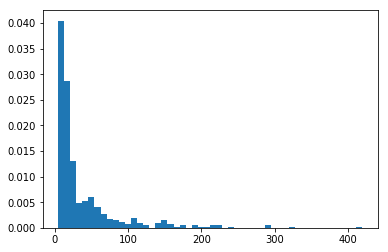

In [216]:
plt.hist(times, density = True, bins = 50)
plt.show()

In [222]:
## Get rid of outliers:
t_max = 220

new_times = []
for t in times:
    if t <= t_max:
        new_times.append(t)

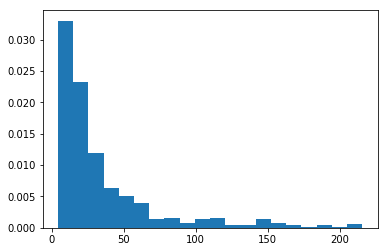

In [224]:
plt.hist(new_times, density = True, bins = 20)
plt.show()

exponential distribution? Not sure